In [1]:
%pylab inline
import sys
sys.path.append('/workspaces/ddhdg/build/src/')

import pyddhdg

Populating the interactive namespace from numpy and matplotlib


In [2]:
DIM = 1

# Description of the domain
LEFT_DOMAIN = 0.
RIGHT_DOMAIN = 6.

UNIT_SCALE = 1e-6

# Properties of the material
Nc = 4.351959895879690e23
Nv = 9.139615903601645e24
Ec = 1.424
Ev = 0

# Doping function constants
R1 = 1 * (RIGHT_DOMAIN / 3.)
R2 = 2 * (RIGHT_DOMAIN / 3.)

ND = 1.0 * Nc
NA = 0.46 * Nv


# Permittivity constants (relative to epsilon0)
eps_r = 12.9

TEMPERATURE = 300


MU_N = 0.85
MU_P = 0.04


def print_doping():
    print('ND = {}'.format(ND))
    print('NA = {}'.format(NA))

    tmp = (Ec + Ev) / 2
    tmp1 = 1/2 * TEMPERATURE * pyddhdg.Constants.kB / pyddhdg.Constants.q * np.log(Nc/Nv)
    print(tmp - tmp1)

In [3]:
def generate_problem(device_type, boundary_condition_handler=None):
    if device_type not in ('n-i-p', 'n-i-n', 'i-i-i'):
        raise ValueError('Invalid device type: {}'.format(device_type))

    # If no boundary conditions, then use homogeneous Dirichlet boundary
    # conditions on the left and on the right and homogeneous neumann boundary
    # conditions on the others sides
    if boundary_condition_handler is None:
        boundary_condition_handler = pyddhdg.BoundaryConditionHandler[DIM]()

        for component in pyddhdg.Components:
            for i in range(2):
                boundary_condition_handler.add_boundary_condition(
                    i,
                    pyddhdg.BoundaryConditionType.DIRICHLET,
                    component,
                    "0"
                )

    eps0 = pyddhdg.Constants.eps0
    permittivity = pyddhdg.HomogeneousPermittivity[DIM](eps_r * eps0)

    temperature = pyddhdg.DealIIFunction[DIM](TEMPERATURE)

    if device_type == 'i-i-i':
        doping = pyddhdg.DealIIFunction[DIM](0)
    else:
        k = -NA
        if device_type == 'n-i-n':
            k = ND
        # Doping is ND from 0 to R1, 0 from R1 to R2 and k from R2 to
        # the end of the domain
        doping = pyddhdg.PiecewiseFunction[DIM](
            pyddhdg.AnalyticFunction[DIM]("{:.2e} - x".format(R1)),
            pyddhdg.DealIIFunction[DIM](ND),
            pyddhdg.PiecewiseFunction[DIM](
                pyddhdg.AnalyticFunction[DIM]("{:.2e} - x".format(R2)),
                pyddhdg.DealIIFunction[DIM](0),
                pyddhdg.DealIIFunction[DIM](k)
            )
        )

    electron_mobility = pyddhdg.HomogeneousMobility[DIM](MU_N, pyddhdg.Components.n)
    hole_mobility = pyddhdg.HomogeneousMobility[DIM](MU_P, pyddhdg.Components.p)

    # We are not using a valid recombination term at the moment
    # Indeed, it is always 0
    recombination_term = pyddhdg.LinearRecombinationTerm[DIM](
        pyddhdg.DealIIFunction[DIM](0.),
        pyddhdg.DealIIFunction[DIM](0.),
        pyddhdg.DealIIFunction[DIM](0.),
    )

    problem = pyddhdg.Problem[DIM](
        left=LEFT_DOMAIN,
        right=RIGHT_DOMAIN,
        permittivity=permittivity,
        electron_mobility=electron_mobility,
        hole_mobility=hole_mobility,
        recombination_term=recombination_term,
        temperature=temperature,
        doping=doping,
        boundary_condition_handler=boundary_condition_handler,
        conduction_band_density=Nc,
        valence_band_density=Nv,
        conduction_band_edge_energy=Ec,
        valence_band_edge_energy=Ev
    )

    return problem


def generate_adimensionalizer():
    adimensionalizer = pyddhdg.Adimensionalizer(
        UNIT_SCALE,
        pyddhdg.Constants.q / pyddhdg.Constants.kB,
        max(ND, NA)
    )
    return adimensionalizer

In [4]:
DEVICE = 'n-i-p'

V_DEGREE = 0
N_AND_P_DEGREE = 0
TAU_V = 1e1
TAU_NP = 1e1


def prepare_solver(boundary_condition_handler=None, verbose=True):
    problem = generate_problem(DEVICE, boundary_condition_handler)
    adimensionalizer = generate_adimensionalizer()
    parameters=pyddhdg.NPSolverParameters['FixedTau'](
        v_degree=V_DEGREE,
        n_degree=N_AND_P_DEGREE,
        p_degree=N_AND_P_DEGREE,
        v_tau=TAU_V,
        n_tau=TAU_NP,
        p_tau=TAU_NP,
        multithreading=False
    )
    s = pyddhdg.NPSolver[DIM](problem, parameters, adimensionalizer, verbose=verbose)
    return s
    
    
def copy_boundary_conditions(s):
    # Prepare the boundary conditions for the real problem (copying the values of the
    # current solution)
    bc = ({}, {})
    # p is a tuple of two points that are in the middle of the left and right boundary
    # faces of the domain
    if DIM == 1:
        p = pyddhdg.Point[DIM](LEFT_DOMAIN), pyddhdg.Point[DIM](RIGHT_DOMAIN)
    else:
        middle = (LEFT_DOMAIN + RIGHT_DOMAIN) * 0.5
        left_pos = [LEFT_DOMAIN] + [middle] * (DIM -1)
        right_pos = [RIGHT_DOMAIN] + [middle] * (DIM -1)
        p = pyddhdg.Point[DIM](*left_pos), pyddhdg.Point[DIM](*right_pos)

    for i in range(2):
        bc[i][pyddhdg.Components.v] = s.get_solution_on_a_point(p[i], pyddhdg.Components.v)

        for cmp in (pyddhdg.Components.n, pyddhdg.Components.p):
            bc[i][cmp] = s.compute_density(
                quasi_fermi_potential=0,
                electric_potential=bc[i][pyddhdg.Components.v],
                temperature=TEMPERATURE,
                component=cmp
            )

    # Put the boundary conditions inside a boundary condition handler
    boundary_condition_handler = pyddhdg.BoundaryConditionHandler[DIM]()
    for cmp in pyddhdg.Components:
        for i in range(2):
            boundary_condition_handler.add_boundary_condition(
                i,
                pyddhdg.BoundaryConditionType.DIRICHLET,
                cmp,
                "{}".format(bc[i][cmp])
            )
    return boundary_condition_handler

    # IGNORE EVERYTHING FROM HERE ON
    new_problem = generate_problem(DEVICE, boundary_condition_handler)
    new_solver = pyddhdg.NPSolver[DIM](new_problem, parameters, adimensionalizer, verbose=True)
    new_solver.copy_triangulation_from(s)
    new_solver.copy_solution_from(s)

    print('Computing the values of n and p at the equilibrium...')
    new_solver.disable_component(pyddhdg.Components.v)
    new_solver.run()
    print('Done!')

    return new_solver


def print_convergence_info(res):
    if res.converged:
        print("Converged in", res.iterations, 'iterations. Last update norm:', res.last_update_norm)
    else:
        print('NOT converged')


In [5]:
# Solve thermodynamical equilibrium

REFINEMENTS = 5

equilibrium_solver = prepare_solver(verbose=True)
equilibrium_solver.refine_grid(REFINEMENTS)

res = equilibrium_solver.compute_thermodynamic_equilibrium()
print_convergence_info(res)

Converged in 4 iterations. Last update norm: 5.824991841660448e-12


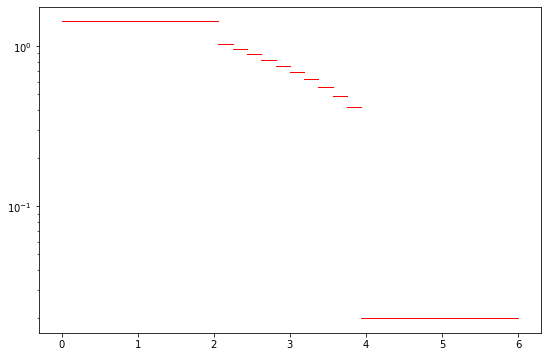

In [6]:
fig = figure(figsize=(9,6))
# equilibrium_solver.plot_solution(pyddhdg.Components.n, colors='green')
# equilibrium_solver.plot_solution(pyddhdg.Components.p, colors='blue')
equilibrium_solver.plot_solution(pyddhdg.Components.v, colors='red')
yscale('log')

In [7]:
traces = equilibrium_solver.get_current_trace_vector()

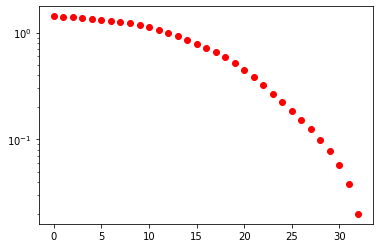

In [8]:
vhat = traces[pyddhdg.Components.v]

plot(vhat, 'ro')
yscale('log')

In [9]:
vhat_new = - traces[pyddhdg.Components.v]

In [14]:
equilibrium_solver.set_current_trace_vector({pyddhdg.Components.v:vhat_new})
traces = equilibrium_solver.get_current_trace_vector()
vhat = traces[pyddhdg.Components.v]

traces[pyddhdg.Components.n]

array([1.03512550e-01, 1.03511073e-01, 1.03508045e-01, 1.03504821e-01,
       1.03501297e-01, 1.03497354e-01, 1.03492866e-01, 1.03487683e-01,
       1.03481636e-01, 1.03474527e-01, 1.03466121e-01, 5.17307928e-02,
       1.21175975e-08, 8.81213339e-10, 6.38021548e-11, 4.61796405e-12,
       3.34237943e-13, 2.41914125e-14, 1.75097738e-15, 1.26791859e-16,
       9.23637105e-18, 6.50775124e-19, 2.69225378e-25, 2.69223114e-25,
       2.69221198e-25, 2.69219569e-25, 2.69218173e-25, 2.69216964e-25,
       2.69215902e-25, 2.69214953e-25, 2.69214084e-25, 2.69213269e-25,
       2.69212871e-25])

In [ ]:

nhat = traces[pyddhdg.Components.n]
phat = traces[pyddhdg.Components.p]

plot(nhat-nhat.min(), 'ro')
plot(phat-phat.min(), 'bo')
yscale('log')


In [ ]:
fig = figure(figsize=(9,6))
# equilibrium_solver.plot_solution(pyddhdg.Components.n, colors='green')
# equilibrium_solver.plot_solution(pyddhdg.Components.p, colors='blue')
equilibrium_solver.plot_solution(pyddhdg.Components.v, colors='red')
yscale('log')

In [ ]:
# Solve only for n and p, given v
bc_for_drift_diffusion = copy_boundary_conditions(equilibrium_solver)

drift_diffusion_solver = prepare_solver(bc_for_drift_diffusion)
drift_diffusion_solver.copy_triangulation_from(equilibrium_solver)
drift_diffusion_solver.copy_solution_from(equilibrium_solver)
drift_diffusion_solver.disable_component(pyddhdg.Components.v)
new_res = drift_diffusion_solver.run()
print_convergence_info(new_res)

In [ ]:
fig = figure(figsize=(9,6))
# equilibrium_solver.plot_solution(pyddhdg.Components.n, colors='green')
# equilibrium_solver.plot_solution(pyddhdg.Components.p, colors='blue')
drift_diffusion_solver.plot_solution(pyddhdg.Components.v, colors='red')
yscale('log')

In [ ]:
traces = solver.get_current_trace_vector()
nhat = traces[pyddhdg.Components.n]
phat = traces[pyddhdg.Components.p]

In [ ]:
fig = figure(figsize=(9,6))
drift_diffusion_solver.plot_solution(pyddhdg.Components.n, colors='green')
drift_diffusion_solver.plot_solution(pyddhdg.Components.p, colors='blue')
yscale('log')

In [ ]:
figure(figsize=(12,6))
plt.yscale('log')
_ = plt.plot(np.abs(residual[pyddhdg.Components.n]), color="green")
_ = plt.plot(np.abs(residual[pyddhdg.Components.p]), color="blue")
# _ = plt.plot(np.abs(residual[pyddhdg.Components.v]), color="red")

In [ ]:
drift_diffusion_solver.enable_component(pyddhdg.Components.v)
new_res = drift_diffusion_solver.run()
print_convergence_info(new_res)

In [ ]:
fig = figure(figsize=(9,6))
drift_diffusion_solver.plot_solution(pyddhdg.Components.n, colors='green')
drift_diffusion_solver.plot_solution(pyddhdg.Components.p, colors='blue')
drift_diffusion_solver.plot_solution(pyddhdg.Components.v, colors='red')

In [ ]:
# Let's check the residual of the full drift diffusion system
drift_diffusion_solver.set_enabled_components(True, True, True)
drift_diffusion_solver.assemble_system()

residual = drift_diffusion_solver.get_residual()

figure(figsize=(12,6))
plt.yscale('log')
_ = plt.plot(np.abs(residual[pyddhdg.Components.n]), color="green")
_ = plt.plot(np.abs(residual[pyddhdg.Components.p]), color="blue")
_ = plt.plot(np.abs(residual[pyddhdg.Components.v]), color="red")

In [ ]:
residual[pyddhdg.Components.n], residual[pyddhdg.Components.p]

In [ ]:
fig = figure(figsize=(9,6))
solver.plot_solution(pyddhdg.Components.n, colors='red')
solver.plot_solution(pyddhdg.Components.p, colors='blue')
yscale('log')

In [ ]:
traces = solver.get_current_trace_vector()

In [ ]:
traces = solver.get_current_trace_vector()
nhat = traces[pyddhdg.Components.n]
phat = traces[pyddhdg.Components.p]

In [ ]:
plot(nhat, 'o')
plot(phat, 'x')
yscale('log')

In [ ]:
nhat